In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import rcParams
from matplotlib.pyplot import figure

import os
for dirname, _, filenames in os.walk('./input/gearbox-fault-diagnosis-stdev'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/gearbox-fault-diagnosis-stdev/broken30hz60.csv
./input/gearbox-fault-diagnosis-stdev/healthy30hz70.csv
./input/gearbox-fault-diagnosis-stdev/broken30hz70.csv
./input/gearbox-fault-diagnosis-stdev/healthy30hz30.csv
./input/gearbox-fault-diagnosis-stdev/broken30hz10.csv
./input/gearbox-fault-diagnosis-stdev/healthy30hz60.csv
./input/gearbox-fault-diagnosis-stdev/broken30hz40.csv
./input/gearbox-fault-diagnosis-stdev/healthy30hz0.csv
./input/gearbox-fault-diagnosis-stdev/healthy30hz90.csv
./input/gearbox-fault-diagnosis-stdev/healthy30hz20.csv
./input/gearbox-fault-diagnosis-stdev/healthy30hz10.csv
./input/gearbox-fault-diagnosis-stdev/broken30hz20.csv
./input/gearbox-fault-diagnosis-stdev/broken30hz90.csv
./input/gearbox-fault-diagnosis-stdev/healthy30hz80.csv
./input/gearbox-fault-diagnosis-stdev/healthy30hz50.csv
./input/gearbox-fault-diagnosis-stdev/broken30hz80.csv
./input/gearbox-fault-diagnosis-stdev/broken30hz30.csv
./input/gearbox-fault-diagnosis-stdev/healthy30hz40.csv
.

# Build dataset
#### Anomalies taken from a small % of broken dataset

In [2]:
# Setting the percentage of outliers. Required to run the KNN algorithm
outlier_fraction = 0.1

In [3]:
# LOAD DATASETS CORRESPONDING TO 50% LOAD
# Healthy gearbox
# ---------------
#  STDEV version (computed every 100 points)
healthy_dataset = pd.read_csv("./input/gearbox-fault-diagnosis-stdev/healthy30hz50.csv")
#  RAW version
#healthy_dataset = pd.read_csv("./input/gearbox-fault-diagnosis/Healthy/h30hz50.csv")
#healthy_dataset['failure'] = 0

# Broken gearbox
# --------------
#  STDEV version (computed every 100 points)
broken_dataset = pd.read_csv("./input/gearbox-fault-diagnosis-stdev/broken30hz50.csv")
#  RAW version
#broken_dataset = pd.read_csv("./input/gearbox-fault-diagnosis/BrokenTooth/b30hz50.csv")
#broken_dataset['failure'] = 1

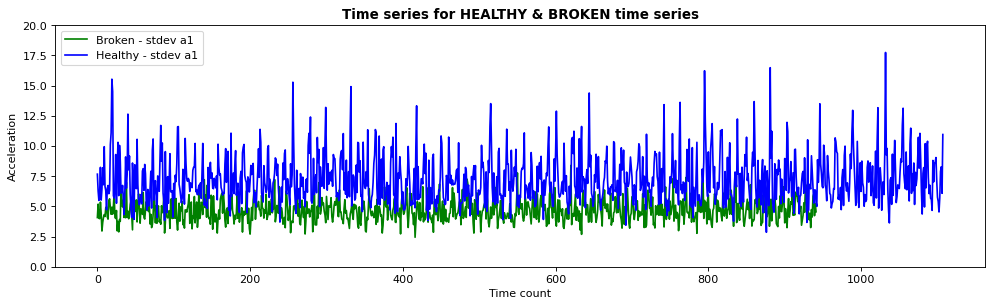

In [4]:
figure(figsize=(15, 4), dpi=80)
broken_dataset['a1'].plot(color='green', label='Broken - stdev a1')
healthy_dataset['a1'].plot(color='blue', label='Healthy - stdev a1')
plt.xlabel('Time count')
plt.ylim(0,20)
plt.ylabel('Acceleration')
plt.legend(loc="upper left")  
plt.title('Time series for HEALTHY & BROKEN time series', fontweight ="bold")
plt.show()

In [5]:
# Generate a combined dataset
healthy_subset = healthy_dataset.sample(frac =1)
broken_subset  = broken_dataset.sample(frac =0.1)
print("There're", broken_subset.shape[0], "points in the BROKEN dataset, vs.", healthy_subset.shape[0], "points in the HEALHTY dataset")

There're 94 points in the BROKEN dataset, vs. 1108 points in the HEALHTY dataset


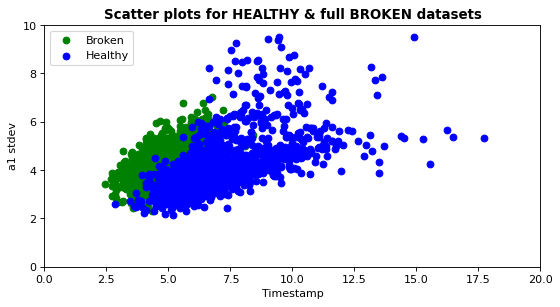

In [6]:
figure(figsize=(8, 4), dpi=80)
plt.scatter(x = broken_dataset['a1'],y = broken_dataset['a2'],color='green', label='Broken')
plt.scatter(x = healthy_dataset['a1'], y = healthy_dataset['a2'],color='blue', label='Healthy')
plt.xlim(0,20)
plt.ylim(0,10)
plt.xlabel('Timestamp')
plt.ylabel('a1 stdev')
plt.legend(loc="upper left")  
plt.title('Scatter plots for HEALTHY & full BROKEN datasets', fontweight ="bold")
plt.show()

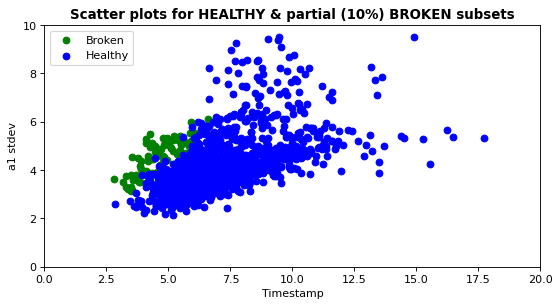

In [7]:
figure(figsize=(8, 4), dpi=80)
plt.scatter(x = broken_subset['a1'],y = broken_subset['a2'],color='green', label='Broken')
plt.scatter(x = healthy_subset['a1'], y = healthy_subset['a2'],color='blue', label='Healthy')
plt.xlim(0,20)
plt.ylim(0,10)
plt.xlabel('Timestamp')
plt.ylabel('a1 stdev')
plt.legend(loc="upper left")  
plt.title('Scatter plots for HEALTHY & partial (10%) BROKEN subsets', fontweight ="bold")
plt.show()

In [8]:
# BROKEN subset does not appear to be outliers,
#   so putting both together will not add prediction capability of failure
dataset = pd.concat([healthy_subset, broken_subset], axis=0)
dataset.describe()

,a1,a2,a3,a4,load,failure
count,1202.000000,1202.000000,1202.000000,1202.000000,1202.0,1202.000000
mean,7.067685,4.299185,4.151460,4.601892,50.0,0.078203
std,2.046729,1.202759,0.918152,1.079442,0.0,0.268603
min,2.790361,2.144350,1.988760,2.149742,50.0,0.000000
25%,5.619849,3.473115,3.483614,3.855476,50.0,0.000000
50%,6.673200,4.035933,4.033213,4.504059,50.0,0.000000
75%,8.224060,4.838111,4.687986,5.229654,50.0,0.000000
max,17.739845,9.528165,7.647036,9.902024,50.0,1.000000


# Run an anomaly detection analysis using KNN algorithm (2 features)
**WARNING:** The decision boundary below is for two features a1, a2
https://www.geeksforgeeks.org/machine-learning-for-anomaly-detection/

In [9]:
import matplotlib.font_manager
from pyod.models.knn import KNN 
from pyod.utils.data import generate_data, get_outliers_inliers

In [10]:
# [1] BUILD THE TRAINING DATA
features = dataset[['a1','a2']] #If selecting only the features in the scatter plot above
X_train = features.values
outcome = dataset[['failure']]
y_train = outcome.values[:,0]

In [11]:
# Storing the outliers and inliners in different numpy arrays
X_outliers, X_inliers = get_outliers_inliers(features.values, outcome)
n_inliers = len(X_inliers)
n_outliers = len(X_outliers)
print("There are", n_inliers, "inliers and", n_outliers, "outliers")

There are 1108 inliers and 94 outliers


In [12]:
# Separating the two features
#f1 = X_train[:, [0]] # .reshape(-1, 1) # This destructures the array f1[:,0]
f1 = features.loc[:,['a1']].values 
f2 = features.loc[:,['a2']].values

Text(0, 0.5, 'Feature 2 (= stev a2)')

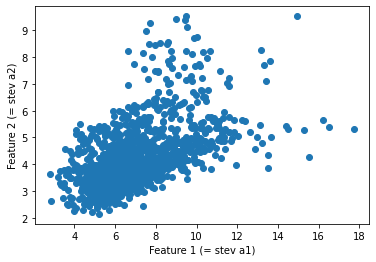

In [13]:
# [2] VISUALIZE THE DATA
# Visualising the dataset
# create a meshgrid
xx, yy = np.meshgrid(np.linspace(0, 20, 200), np.linspace(0, 20, 200)) # Set the limits to your case: 0 to 20
# If extending to 3D
#xx, yy, zz = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))

# scatter plot
plt.scatter(f1, f2) # ,f3) if extending to 3D
plt.xlabel('Feature 1 (= stev a1)')
plt.ylabel('Feature 2 (= stev a2)')

In [14]:
# [3] TRAIN THE MODEL for only 2 features AND EVALUATE

# Training the classifier. It requires outlier_fraction to be defined above
clf = KNN(contamination = outlier_fraction)
clf.fit(X_train, y_train)
  
# You can print this to see all the prediciton scores
scores_pred = clf.decision_function(X_train)*-1
  
y_pred = clf.predict(X_train)
n_errors = (y_pred != y_train).sum()

/opt/conda/lib/python3.7/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


In [15]:
# Counting the number of errors  
print('The number of prediction errors are', n_errors, ', equal to ', "{:.2f}".format(n_errors/y_train.shape[0]*100), '% out of', y_train.shape[0], 'data points')

The number of prediction errors are 183 , equal to  15.22 % out of 1202 data points


In [16]:
# [4] VISUALIZING THE PREDICTIONS

# threshold value to consider a
# datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred, 100 * outlier_fraction)
threshold

-0.34840884637645786

In [17]:
# decision function calculates the raw 
# anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
# Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel() , zz.ravel()]) * -1 # If extending to 3D
Z = Z.reshape(xx.shape)

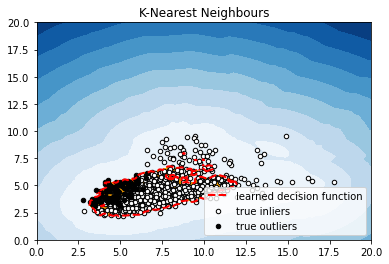

In [18]:
# fill blue colormap from minimum anomaly
# score to threshold value
subplot = plt.subplot(1, 1, 1)
subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), 
                  threshold, 10), cmap = plt.cm.Blues_r)

# draw red contour line where anomaly 
# score is equal to threshold
a = subplot.contour(xx, yy, Z, levels =[threshold],
                     linewidths = 2, colors ='red')

# fill orange contour lines where range of anomaly
# score is from threshold to maximum anomaly score
subplot.contourf(xx, yy, Z, levels =[threshold, Z.max()], colors ='orange')
  
# scatter plot of inliers with white dots
b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1],
                                    c ='white', s = 20, edgecolor ='k') 
  
# scatter plot of outliers with black dots
c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], 
                                    c ='black', s = 20, edgecolor ='k')
subplot.axis('tight')

subplot.legend(
    [a.collections[0], b, c],
    ['learned decision function', 'true inliers', 'true outliers'],
    prop = matplotlib.font_manager.FontProperties(size = 10),
    loc ='lower right')
  
subplot.set_title('K-Nearest Neighbours')
subplot.set_xlim((0, 20))
subplot.set_ylim((0, 20))
plt.show() 

!!! True outliers correspond to broken subset, and all are within the decision boundary
     So KNN has no predictive capability => 14.98% error above does not really measure false (broken) data points
### CONCLUSION: Outliers prediction does not identify broken data points (proved using KNN algorithm)

# Run the KNN anomaly detection analysis including all features
## 50% load case
**WARNING:** The decision boundary above is just for the two features a1, a2. Not plotted now

In [19]:
filename = "healthy30hz50.csv"
healthy_dataset = pd.read_csv("./input/gearbox-fault-diagnosis-stdev/" + filename)
filename = "broken30hz50.csv"
broken_dataset = pd.read_csv("./input/gearbox-fault-diagnosis-stdev/" + filename)

In [20]:
# Generate a combined dataset
healthy_subset = healthy_dataset.sample(frac =1)
broken_subset  = broken_dataset.sample(frac =0.1)
print("There're", broken_subset.shape[0], "points in the BROKEN dataset, vs.", healthy_subset.shape[0], "points in the HEALHTY dataset")

dataset = pd.concat([healthy_subset, broken_subset], axis=0)
dataset.describe()

There're 94 points in the BROKEN dataset, vs. 1108 points in the HEALHTY dataset


,a1,a2,a3,a4,load,failure
count,1202.000000,1202.000000,1202.000000,1202.000000,1202.0,1202.000000
mean,7.057101,4.288222,4.146202,4.591408,50.0,0.078203
std,2.066560,1.208383,0.928096,1.094123,0.0,0.268603
min,2.683940,2.144350,1.988760,2.072062,50.0,0.000000
25%,5.625177,3.469325,3.471564,3.819879,50.0,0.000000
50%,6.683093,4.017275,4.026390,4.513311,50.0,0.000000
75%,8.224060,4.804713,4.687986,5.219336,50.0,0.000000
max,17.739845,9.528165,7.647036,9.902024,50.0,1.000000


In [21]:
# [1] BUILD THE TRAINING DATA
features = dataset[['a1','a2','a3','a4']] #If selecting only the features in the scatter plot above
X_train = features.values
outcome = dataset[['failure']]
y_train = outcome.values[:,0]

In [22]:
# [2] COMPUTINHG OUTLIERS
# Storing the outliers and inliners in different numpy arrays
X_outliers, X_inliers = get_outliers_inliers(features.values, outcome)
n_inliers = len(X_inliers)
n_outliers = len(X_outliers)
print("There are", n_inliers, "inliers and", n_outliers, "outliers")

There are 1108 inliers and 94 outliers


In [23]:
# [3] TRAIN THE MODEL AND EVALUATE

# Training the classifier
clf = KNN(contamination = outlier_fraction)
clf.fit(X_train, y_train)
  
# You can print this to see all the prediciton scores
scores_pred = clf.decision_function(X_train)*-1
  
y_pred = clf.predict(X_train)
n_errors = (y_pred != y_train).sum()

/opt/conda/lib/python3.7/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


In [24]:
# Counting the number of errors  
print('The number of prediction errors are', n_errors, ', equal to ', "{:.2f}".format(n_errors/y_train.shape[0]*100), '% out of', y_train.shape[0], 'data points')

The number of prediction errors are 154 , equal to  12.81 % out of 1202 data points


## 90% load case

In [25]:
filename = "healthy30hz90.csv"
healthy_dataset = pd.read_csv("./input/gearbox-fault-diagnosis-stdev/" + filename)
filename = "broken30hz90.csv"
broken_dataset = pd.read_csv("./input/gearbox-fault-diagnosis-stdev/" + filename)

In [26]:
# Generate a combined dataset
healthy_subset = healthy_dataset.sample(frac =1)
broken_subset  = broken_dataset.sample(frac =0.1)
print("There're", broken_subset.shape[0], "points in the BROKEN dataset, vs.", healthy_subset.shape[0], "points in the HEALHTY dataset")

dataset = pd.concat([healthy_subset, broken_subset], axis=0)
dataset.describe()

There're 106 points in the BROKEN dataset, vs. 1067 points in the HEALHTY dataset


,a1,a2,a3,a4,load,failure
count,1173.000000,1173.000000,1173.000000,1173.000000,1173.0,1173.000000
mean,7.799350,4.482930,4.530108,5.132824,90.0,0.090367
std,2.005882,1.006967,0.889499,1.027604,0.0,0.286829
min,2.990430,2.094819,2.175081,2.463140,90.0,0.000000
25%,6.366431,3.742483,3.872858,4.446925,90.0,0.000000
50%,7.614868,4.352070,4.489746,5.099781,90.0,0.000000
75%,9.070146,5.070917,5.130872,5.780837,90.0,0.000000
max,23.909199,8.432767,8.273939,9.674538,90.0,1.000000


In [27]:
# [1] BUILD THE TRAINING DATA
features = dataset[['a1','a2','a3','a4']] #If selecting only the features in the scatter plot above
X_train = features.values
outcome = dataset[['failure']]
y_train = outcome.values[:,0]

# [2] COMPUTING OUTLIERS
# Storing the outliers and inliners in different numpy arrays
X_outliers, X_inliers = get_outliers_inliers(features.values, outcome)
n_inliers = len(X_inliers)
n_outliers = len(X_outliers)
print("There are", n_inliers, "inliers and", n_outliers, "outliers")

# [3] TRAIN THE MODEL AND EVALUATE
# Training the classifier
clf = KNN(contamination = outlier_fraction)
clf.fit(X_train, y_train)
scores_pred = clf.decision_function(X_train)*-1
y_pred = clf.predict(X_train)
n_errors = (y_pred != y_train).sum()
print('The number of prediction errors are', n_errors, ', equal to ', "{:.2f}".format(n_errors/y_train.shape[0]*100), '% out of', y_train.shape[0], 'data points')

There are 1067 inliers and 106 outliers


/opt/conda/lib/python3.7/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


The number of prediction errors are 136 , equal to  11.59 % out of 1173 data points


# 0% load case

In [28]:
filename = "healthy30hz0.csv"
healthy_dataset = pd.read_csv("./input/gearbox-fault-diagnosis-stdev/" + filename)
filename = "broken30hz0.csv"
broken_dataset = pd.read_csv("./input/gearbox-fault-diagnosis-stdev/" + filename)

In [29]:
# Generate a combined dataset
healthy_subset = healthy_dataset.sample(frac =1)
broken_subset  = broken_dataset.sample(frac =0.1)
print("There're", broken_subset.shape[0], "points in the BROKEN dataset, vs.", healthy_subset.shape[0], "points in the HEALHTY dataset")

dataset = pd.concat([healthy_subset, broken_subset], axis=0)
dataset.describe()

There're 88 points in the BROKEN dataset, vs. 888 points in the HEALHTY dataset


,a1,a2,a3,a4,load,failure
count,976.000000,976.000000,976.000000,976.000000,976.0,976.000000
mean,5.453872,3.875793,3.148541,3.229269,0.0,0.090164
std,1.975203,1.538055,0.848756,0.889478,0.0,0.286563
min,1.852285,1.272738,1.071922,1.252334,0.0,0.000000
25%,3.962571,2.838112,2.531290,2.546129,0.0,0.000000
50%,5.147320,3.531367,3.057821,3.203044,0.0,0.000000
75%,6.693841,4.426496,3.705702,3.823508,0.0,0.000000
max,14.025923,10.374287,6.067145,6.395715,0.0,1.000000


In [30]:
# [1] BUILD THE TRAINING DATA
features = dataset[['a1','a2','a3','a4']] #If selecting only the features in the scatter plot above
X_train = features.values
outcome = dataset[['failure']]
y_train = outcome.values[:,0]

# [2] COMPUTINHG OUTLIERS
# Storing the outliers and inliners in different numpy arrays
X_outliers, X_inliers = get_outliers_inliers(features.values, outcome)
n_inliers = len(X_inliers)
n_outliers = len(X_outliers)
print("There are", n_inliers, "inliers and", n_outliers, "outliers")

# [3] TRAIN THE MODEL AND EVALUATE
# Training the classifier
clf = KNN(contamination = outlier_fraction)
clf.fit(X_train, y_train)
scores_pred = clf.decision_function(X_train)*-1
y_pred = clf.predict(X_train)
n_errors = (y_pred != y_train).sum()
print('The number of prediction errors are', n_errors, ', equal to ', "{:.2f}".format(n_errors/y_train.shape[0]*100), '% out of', y_train.shape[0], 'data points')

There are 888 inliers and 88 outliers


/opt/conda/lib/python3.7/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")


The number of prediction errors are 136 , equal to  13.93 % out of 976 data points
